In [7]:
%matplotlib notebook
import numpy as np
from PIL import Image

import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning
from skimage.transform import downscale_local_mean #For binning
from skimage.filters import threshold_otsu, threshold_local

from statistics import median
from statistics import mode
import math 

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   
3
import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

In [33]:
np.set_printoptions(threshold=sys.maxsize)

def rows_n_cols(im):
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    return rows, cols

def show_raw_images(row, ax, i, frame_key):
    plt.gray()
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        test_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+")", fontsize=10)
    ax.imshow(test_image) #cmap = 'gray'
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(row, ax, i, frame_key, block_size, offset_val):
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        threshold_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
        threshold_image = threshold_images(raw_image, block_size, offset_val)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def floodfill_flat(array, x, y, rows, cols):
    stack = []
    if array[x,y] != 1:
        return 0
    stack.append((x,y))
    currclustersize = 1
    array[x,y] = 2
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == 1:
                array[xcurr-1,ycurr] = 2
                currclustersize += 1
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == 1:
                array[xcurr+1,ycurr] = 2
                currclustersize += 1
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == 1:
                array[xcurr,ycurr-1] = 2
                currclustersize += 1
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == 1:
                array[xcurr,ycurr+1] = 2
                currclustersize += 1
                stack.append((xcurr,ycurr+1))
    return currclustersize

def markcluster_flat(array, x, y, rows, cols, clustersize):
    stack = []
    if array[x,y] != 2:
        return
    stack.append((x,y))
    array[x,y] = clustersize
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == 2:
                array[xcurr-1,ycurr] = clustersize
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == 2:
                array[xcurr+1,ycurr] = clustersize
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == 2:
                array[xcurr,ycurr-1] = clustersize
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == 2:
                array[xcurr,ycurr+1] = clustersize
                stack.append((xcurr,ycurr+1))

def threshold_images(image, block_size, offset_val):
    ed_image = (image**0.2)*500
    ed_thresh = threshold_local(ed_image, block_size, offset= offset_val)
    #ed_binary_im = (ed_image > ed_thresh)
    #print(ed_binary_im[:2])
    ed_binary_im = 1*(ed_image > ed_thresh)
    #print(ed_binary_im[:2])
    #print(ed_binary_im.shape)
    return ed_binary_im

def cluster_analysis(size_lim, i, row_num, arraythresh, rows, cols):
    clusters = []
    for x in range(rows):
        #if x % 25 == 0:  #progress update
        #    print(100*x/rows)
        for y in range(cols):
            if arraythresh[x,y] == 1:
                #fill in this cluster
                clustersize = floodfill_flat(arraythresh, x, y, rows, cols)
                if clustersize >= size_lim:
                    clusters.append(clustersize)
                    #markcluster_flat(arraythresh,x,y,rows,cols,clustersize)
                    #print("clustersize= %5.3f for (x,y)= (%5.3f, %5.3f)"  %(clustersize,x,y))
                    #print(arraythresh)
                #mark finished cluster with size
                
       
    '''for q in range(clusters.count(1)):
        clusters.remove(1)
    
    print(clusters)
    clusters.sort()
    print(clusters)
    if clusters[0] < size_lim:
        keep_going = True
        while keep_going:
            if clusters[0] < size_lim:
                m = clusters[0]
                clusters.remove(m)
            else:
                keep_going = False'''
                                           #max_size = (max(clusters)) * (pixel_size**2)  
    clusters.sort()
    bottom_decile = clusters[math.floor(len(clusters)/10)]
    top_decile = clusters[math.floor(9*len(clusters)/10)]
    FW = top_decile - bottom_decile
    
    total_num = len(clusters)
    mean_size = (sum(clusters) / len(clusters)) * (pixel_size**2)  #pixel size squared b/c max size is an area
    median_size = (median(clusters)) * (pixel_size**2)
    mode_size = (mode(clusters)) * (pixel_size**2)
    
    if (i == 0) and (row_num == 1):
        print(clusters)
    
    #print("for row"+str(row_num)+", t= "+str(time_array[i]) + " hrs:")
    print('   clusters counted: %5i, mean size: %5.3f, median: %5.3f, mode: %5.3f' %(total_num, mean_size, 
                                                                                       median_size, mode_size))
    
    return total_num, mean_size, median_size, mode_size, clusters

In [6]:
import math 
clust = [1,2,3,4,5,6,7,3,53,634,567,567,3456,464,65,6,6,5,34,3456,67,6,4,3,554,65,7,544,5,7,7,2,34,42,3,3,23,17,24,5,10,15,20]
#sorted(clust)
clust.sort()
bottom_decile = clust[math.floor(len(clust)/10)]
top_decile = clust[math.floor(9*len(clust)/10)]
FW = top_decile - bottom_decile
print(bottom_decile, top_decile, FW)

3 567 564


In [ ]:
clust.sort()
if clust[0] < 30:
    keep_going = True
    while keep_going:
        if clust[0] < 30:
            m = clust[0]
            clust.remove(m)
        else:
            keep_going = False
            print(clust)

In [57]:
directory = "X"
exp = "10-15-22_s2_theBigOne2"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\"
### "plot_saveto" is the pathway to the folder where plots and results will be saved
saveto_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\threshold results\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 54 files
 0 	 row1_t1.tif
 1 	 row1_t2.tif
 2 	 row1_t3.tif
 3 	 row1_t4.tif
 4 	 row1_t5.tif
 5 	 row1_t6.tif
 6 	 row1_t7.tif
 7 	 row1_t8.tif
 8 	 row1_t9.tif
 9 	 row2_t1.tif
 10 	 row2_t2.tif
 11 	 row2_t3.tif
 12 	 row2_t4.tif
 13 	 row2_t5.tif
 14 	 row2_t6.tif
 15 	 row2_t7.tif
 16 	 row2_t8.tif
 17 	 row2_t9.tif
 18 	 row3_t1.tif
 19 	 row3_t2.tif
 20 	 row3_t3.tif
 21 	 row3_t4.tif
 22 	 row3_t5.tif
 23 	 row3_t6.tif
 24 	 row3_t7.tif
 25 	 row3_t8.tif
 26 	 row3_t9.tif
 27 	 row4_t1.tif
 28 	 row4_t2.tif
 29 	 row4_t3.tif
 30 	 row4_t4.tif
 31 	 row4_t5.tif
 32 	 row4_t6.tif
 33 	 row4_t7.tif
 34 	 row4_t8.tif
 35 	 row4_t9.tif
 36 	 row5_t1.tif
 37 	 row5_t2.tif
 38 	 row5_t3.tif
 39 	 row5_t4.tif
 40 	 row5_t5.tif
 41 	 row5_t6.tif
 42 	 row5_t7.tif
 43 	 row5_t8.tif
 44 	 row5_t9.tif
 45 	 row6_t1.tif
 46 	 row6_t2.tif
 47 	 row6_t3.tif
 48 	 row6_t4.tif
 49 	 row6_t5.tif
 50 	 row6_t6.tif
 51 	 row6_t7.tif
 52 	 row6_t8.tif
 53 	 row6_t9.tif


In [10]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]
total_rows = 6
#s1 [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]
#s2 [1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.091 
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/6)
print("total number of time points: "+ str(arr_length))
if arr_length % 2 == 0:
    num_rows = int(arr_length/2)
else:
    num_rows = int((arr_length+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

font_size = 16  ### font size
dpi_num = 600  ### image quality level (recommendation: 600)

C:\Users\gleech\Documents\GitHub\best-cluster-analysis\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


tiff file dimensions: (5, 1440, 1920)
total number of time points: 9
(for image previews) number of rows = 5


# For better results, we filter & 'skeletonize' the images before analysis 
### Do we need to filter out background noise from the images? If so, we can try out different filter sizes to see which works best. The following block previews the images intended for SIA analysis, showing the filtered and skeletonized images
'skeletonize' means we find a specific threshold (based on median intensity), so all pixel values above that threshold = 1, and all pixel values below that threshold = 0. This gives structures clean borders for improved correlation analysis, g(r).

In [ ]:
frame_key = 0
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
print("condition: "+condition)

block_size = 1051
offset_val = -20

row = 1
### choose which set of tiff files should be analyzed, row1, row2 or row3

fig_height = num_rows*2.3
time_array.append(0)
i = 0
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_raw_images(row, ax, i, frame_key)
    else:
        show_threshold_images(row, ax, i, frame_key, block_size, offset_val)
        i = i + 1 
plt.show()
time_array.remove(0)
print(time_array)
details = " (row"+str(row)+", bsize= "+str(block_size)+", offset= "+str(offset_val)+")"

### option to save this figure (uncomment below)
#fig.savefig(saveto_dir+"threshold images for "+condition+details+".jpg", dpi=dpi_num)

In [51]:
frame_key = 1
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
block_size = 1051
offset_val = -20

row1_thresh = [0.0] * int(arr_length)
row2_thresh = [0.0] * int(arr_length)
row3_thresh = [0.0] * int(arr_length)
row4_thresh = [0.0] * int(arr_length)
row5_thresh = [0.0] * int(arr_length)
row6_thresh = [0.0] * int(arr_length)

row1_results = [0.0] * int(arr_length)
row2_results = [0.0] * int(arr_length)
row3_results = [0.0] * int(arr_length)
row4_results = [0.0] * int(arr_length)
row5_results = [0.0] * int(arr_length)
row6_results = [0.0] * int(arr_length)
print("condition: "+condition)
rows, cols, = rows_n_cols(threshold_images(tiff_file.imread(files[0],key=[frame_key]), block_size, offset_val))
print(rows, cols)

beads_per_cluster = 5
size_lim = int( (beads_per_cluster*0.785) / (pixel_size**2) ) + 2 #add 2 to round up just for good measure (i.e. 473+2=475)     
### 2D bead area = pi*(0.5 um)^2 = 0.785 um^2
# e.g (5 beads)(0.785 um^2) = 3.93 um^2 ---> (3.93 um^2)/((0.091 um/px)^2) = ~475 pixels^2
print("define clusters as at least: "+str(beads_per_cluster)+" beads --> size_lim = "+str(size_lim)+" pixels^2")

condition: WT (no kA)
1440 1920
define clusters as at least: 5 beads --> size_lim = 475 pixels^2


In [52]:
'''image = tiff_file.imread(files[0],key=[frame_key])
image = image[:200, :200]
rows, cols, = rows_n_cols(threshold_images(image, block_size, offset_val))
row1_thresh[0] = threshold_images(image, block_size, offset_val)
r1_total_num, r1_mean_size, r1_median_size, r1_mode_size, clusters = cluster_analysis(size_lim, i, 1, row1_thresh[0], rows, cols)'''

'image = tiff_file.imread(files[0],key=[frame_key])\nimage = image[:200, :200]\nrows, cols, = rows_n_cols(threshold_images(image, block_size, offset_val))\nrow1_thresh[0] = threshold_images(image, block_size, offset_val)\nr1_total_num, r1_mean_size, r1_median_size, r1_mode_size, clusters = cluster_analysis(size_lim, i, 1, row1_thresh[0], rows, cols)'

In [53]:
#frame_key = 0
cmap = matplotlib.cm.get_cmap('Blues')

block_size = 1051
offset_val = -20

for i in range(arr_length):
    row1_thresh[i] = threshold_images(tiff_file.imread(files[i],key=[frame_key]), block_size, offset_val)
    row2_thresh[i] = threshold_images(tiff_file.imread(files[i+arr_length], key=[frame_key]), block_size, offset_val)
    row3_thresh[i] = threshold_images(tiff_file.imread(files[i+(arr_length*2)],key=[frame_key]), block_size, offset_val)
    row4_thresh[i] = threshold_images(tiff_file.imread(files[i+(arr_length*3)],key=[frame_key]), block_size, offset_val)
    row5_thresh[i] = threshold_images(tiff_file.imread(files[i+(arr_length*4)],key=[frame_key]), block_size, offset_val)
    row6_thresh[i] = threshold_images(tiff_file.imread(files[i+(arr_length*5)],key=[frame_key]), block_size, offset_val)
    
    r1_total_num, r1_mean_size, r1_median_size, r1_mode_size, r1_clusters = cluster_analysis(size_lim, i, 1, row1_thresh[i], rows, cols)
    r2_total_num, r2_mean_size, r2_median_size, r2_mode_size, r2_clusters = cluster_analysis(size_lim, i, 2, row2_thresh[i], rows, cols)
    r3_total_num, r3_mean_size, r3_median_size, r3_mode_size, r3_clusters = cluster_analysis(size_lim, i, 3, row3_thresh[i], rows, cols)
    r4_total_num, r4_mean_size, r4_median_size, r4_mode_size, r4_clusters = cluster_analysis(size_lim, i, 4, row4_thresh[i], rows, cols)
    r5_total_num, r5_mean_size, r5_median_size, r5_mode_size, r5_clusters = cluster_analysis(size_lim, i, 5, row5_thresh[i], rows, cols)
    r6_total_num, r6_mean_size, r6_median_size, r6_mode_size, r6_clusters = cluster_analysis(size_lim, i, 6, row6_thresh[i], rows, cols)
    
    row1_results[i] = (r1_total_num, r1_mean_size, r1_median_size, r1_mode_size)
    row2_results[i] = (r2_total_num, r2_mean_size, r2_median_size, r2_mode_size)
    row3_results[i] = (r3_total_num, r3_mean_size, r3_median_size, r3_mode_size)
    row4_results[i] = (r4_total_num, r4_mean_size, r4_median_size, r4_mode_size)
    row5_results[i] = (r5_total_num, r5_mean_size, r5_median_size, r5_mode_size)
    row6_results[i] = (r6_total_num, r6_mean_size, r6_median_size, r6_mode_size)

[476, 485, 498, 498, 501, 502, 503, 505, 505, 506, 506, 521, 523, 524, 533, 544, 549, 557, 569, 578, 580, 582, 590, 593, 597, 608, 609, 612, 621, 623, 630, 631, 639, 642, 643, 660, 661, 662, 667, 668, 673, 675, 676, 682, 690, 705, 724, 739, 743, 748, 751, 755, 757, 759, 766, 775, 777, 780, 792, 799, 804, 810, 832, 840, 842, 847, 876, 895, 918, 924, 928, 933, 955, 963, 975, 983, 999, 1013, 1024, 1049, 1065, 1094, 1128, 1154, 1158, 1187, 1213, 1238, 1240, 1246, 1247, 1268, 1288, 1300, 1304, 1318, 1321, 1370, 1378, 1411, 1425, 1427, 1441, 1482, 1523, 1528, 1531, 1538, 1550, 1610, 1629, 1654, 1680, 1681, 1685, 1704, 1714, 1734, 1754, 1838, 1843, 1863, 1884, 1891, 1894, 1910, 1993, 2052, 2058, 2077, 2078, 2116, 2118, 2135, 2153, 2161, 2202, 2396, 2480, 2504, 2625, 2647, 2725, 2768, 2861, 2878, 2968, 2986, 3082, 3086, 3124, 3130, 3201, 3695, 3864, 4102, 4190, 4240, 4316, 4347, 4751, 4768, 4770, 4915, 5028, 5036, 5191, 5247, 5532, 6081, 7829, 8687, 9141, 13214]
   clusters counted:   174, mea

<IPython.core.display.Javascript object>


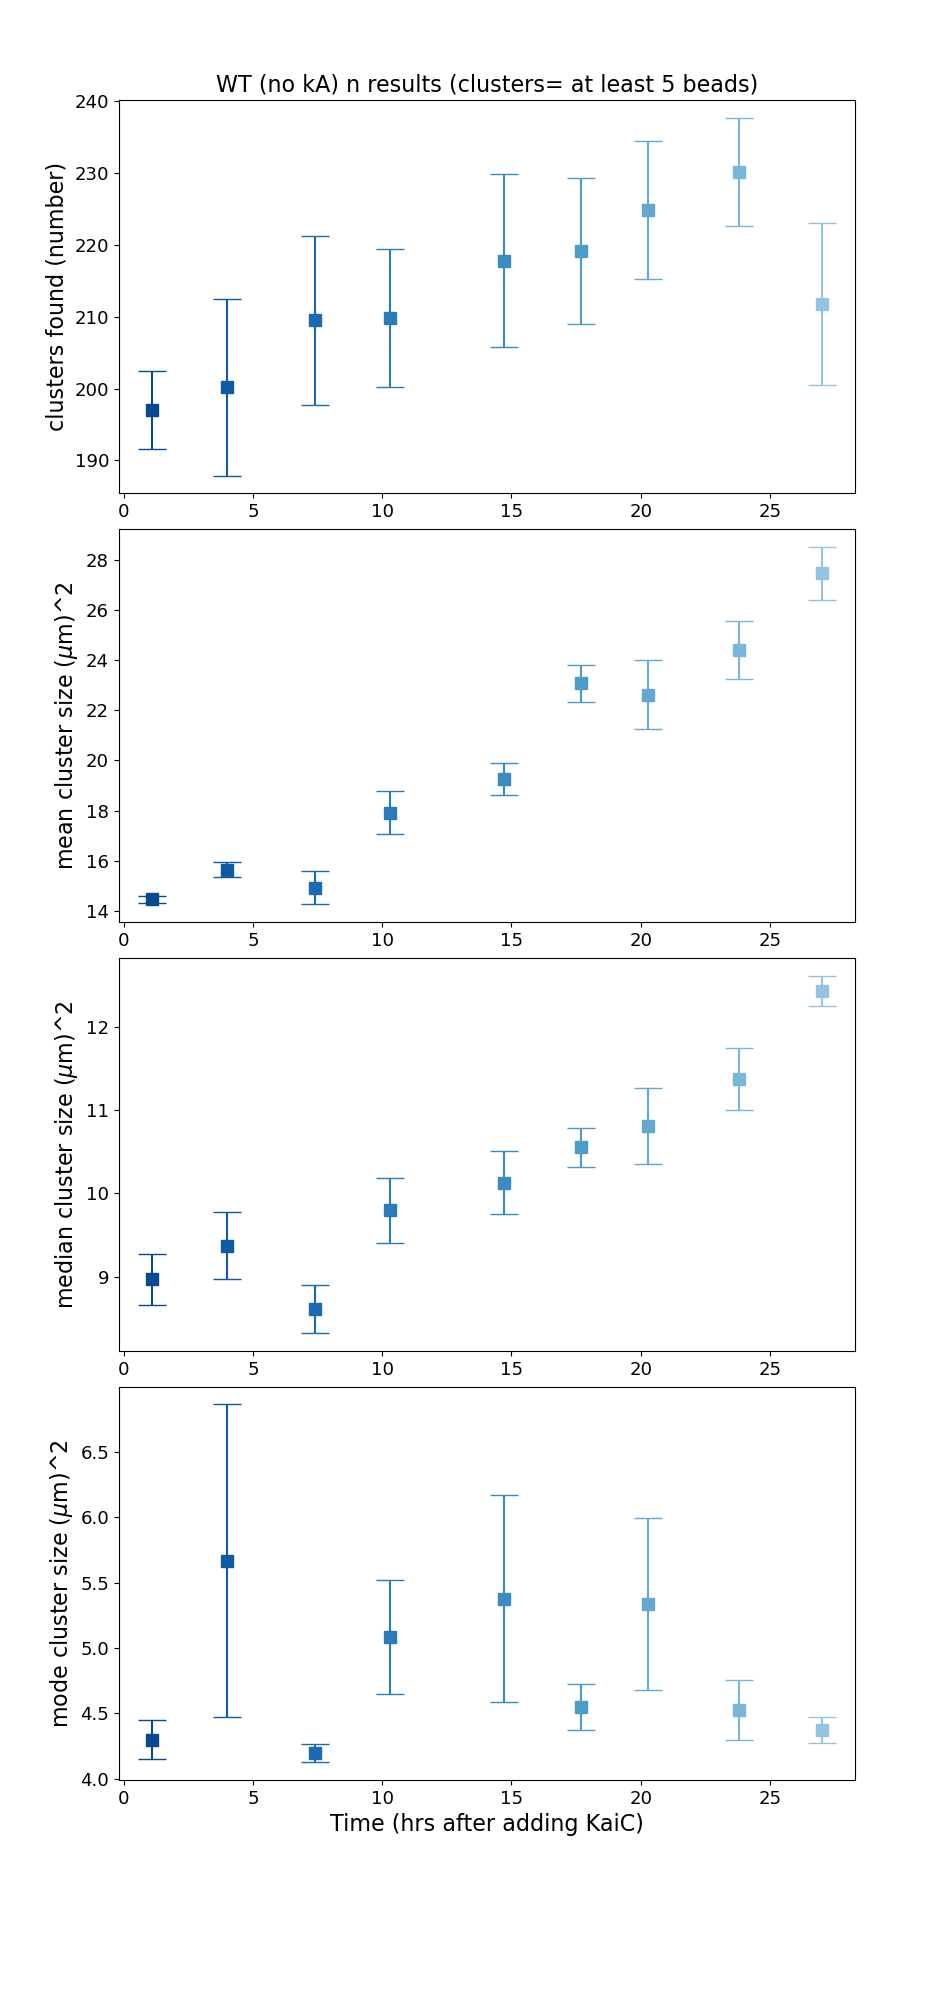

In [54]:
cmap_num = (arr_length*2) - 2
fig_size = 9.5, 20   #20/1.618

### set up empty arrays
all_total_num = np.zeros((total_rows,len(row1_results)))
avg_total_num = np.empty(len(row1_results))
stderror_total_num = np.empty(len(row1_results))

### find average values and std. error 
for i in range(len(row1_results)):
    all_total_num[0,i] = row1_results[i][0]
    all_total_num[1,i] = row2_results[i][0]
    all_total_num[2,i] = row3_results[i][0]
    all_total_num[3,i] = row4_results[i][0]
    all_total_num[4,i] = row5_results[i][0]
    all_total_num[5,i] = row6_results[i][0]
avg_total_num = all_total_num.mean(axis=0)
stderror_total_num = all_total_num.std(axis=0)/np.sqrt(6)

### same process for the other output results
all_mean_size = np.zeros((6,len(row1_results)))
avg_mean_size = np.empty(len(row1_results))
stderror_mean_size = np.empty(len(row1_results))
for i in range(len(row1_results)):
    all_mean_size[0,i] = row1_results[i][1]
    all_mean_size[1,i] = row2_results[i][1]
    all_mean_size[2,i] = row3_results[i][1]
    all_mean_size[3,i] = row4_results[i][1]
    all_mean_size[4,i] = row5_results[i][1]
    all_mean_size[5,i] = row6_results[i][1]
avg_mean_size = all_mean_size.mean(axis=0)
stderror_mean_size = all_mean_size.std(axis=0)/np.sqrt(6)

all_median_size = np.zeros((6,len(row1_results)))
avg_median_size = np.empty(len(row1_results))
stderror_median_size = np.empty(len(row1_results))
for i in range(len(row1_results)):
    all_median_size[0,i] = row1_results[i][2]
    all_median_size[1,i] = row2_results[i][2]
    all_median_size[2,i] = row3_results[i][2]
    all_median_size[3,i] = row4_results[i][2]
    all_median_size[4,i] = row5_results[i][2]
    all_median_size[5,i] = row6_results[i][2]
avg_median_size = all_median_size.mean(axis=0)
stderror_median_size = all_median_size.std(axis=0)/np.sqrt(6)

all_mode_size = np.zeros((6,len(row1_results)))
avg_mode_size = np.empty(len(row1_results))
stderror_mode_size = np.empty(len(row1_results))
for i in range(len(row1_results)):
    all_mode_size[0,i] = row1_results[i][3]
    all_mode_size[1,i] = row2_results[i][3]
    all_mode_size[2,i] = row3_results[i][3]
    all_mode_size[3,i] = row4_results[i][3]
    all_mode_size[4,i] = row5_results[i][3]
    all_mode_size[5,i] = row6_results[i][3]
avg_mode_size = all_mode_size.mean(axis=0)
stderror_mode_size = all_mode_size.std(axis=0)/np.sqrt(6)

### plot average values and std. error for L1 correlation lengths
fig = plt.figure(figsize=(fig_size))
gs = fig.add_gridspec(4, top=0.95, hspace=0.09)
axs = gs.subplots(sharex=False, sharey=False)
#fig, axs = plt.subplots(3, figsize=(fig_size))
markerSize = 8
title = condition +" n results (clusters= at least "+str(beads_per_cluster)+" beads)"

for i in range(int(len(time_array))):
    axs[0].set_title(title, fontsize= (font_size))
    axs[0].set( ylabel='clusters found (number)')
    #axs[0].set_ylim(0, 400)
    axs[0].plot(time_array[i], avg_total_num[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "max cluster size")
    axs[0].errorbar(time_array[i], avg_total_num[i], yerr = stderror_total_num[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[1].set( ylabel='mean cluster size ($\mu$m)^2')
    #axs[1].set_ylim(0, 60)
    axs[1].plot(time_array[i], avg_mean_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[1].errorbar(time_array[i], avg_mean_size[i], yerr = stderror_mean_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[2].set( ylabel='median cluster size ($\mu$m)^2')
    #axs[2].set_ylim(0, 60)
    axs[2].plot(time_array[i], avg_median_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[2].errorbar(time_array[i], avg_median_size[i], yerr = stderror_median_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[3].set( ylabel='mode cluster size ($\mu$m)^2')
    axs[3].set( xlabel="Time (hrs after adding KaiC)")
    #axs[3].set_ylim(0, 30)
    axs[3].plot(time_array[i], avg_mode_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[3].errorbar(time_array[i], avg_mode_size[i], yerr = stderror_mode_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=(font_size-3))
    ax.xaxis.get_label().set_fontsize(font_size)
    ax.yaxis.get_label().set_fontsize(font_size)

#plt.subplot_tool()
plt.show()
fig.savefig(saveto_dir+title+".jpg", dpi=dpi_num)

In [55]:
csv_data_file = exp+"-- results (clusters= at least "+str(beads_per_cluster)+" beads)"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title])
        writer.writerow(['clusters detected','','','','','','','','','',
                         'mean cluster size','','','','','','','','','',
                         'median cluster size','','','','','','','','',
                         'mode cluster size',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], row4_results[i][0],
                             row5_results[i][0], row6_results[i][0], avg_total_num[i], stderror_total_num[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], row4_results[i][1], 
                             row5_results[i][1], row6_results[i][1], avg_mean_size[i], stderror_mean_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], row4_results[i][2], 
                             row5_results[i][2], row6_results[i][2], avg_median_size[i], stderror_median_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], row4_results[i][3], 
                             row5_results[i][3], row6_results[i][3], avg_mode_size[i], stderror_mode_size[i],'',])
        writer.writerow([''])
        
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title])
        writer.writerow(['clusters detected','','','','','','','','','',
                         'mean cluster size','','','','','','','','','',
                         'median cluster size','','','','','','','','',
                         'mode cluster size',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], row4_results[i][0],
                             row5_results[i][0], row6_results[i][0], avg_total_num[i], stderror_total_num[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], row4_results[i][1], 
                             row5_results[i][1], row6_results[i][1], avg_mean_size[i], stderror_mean_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], row4_results[i][2], 
                             row5_results[i][2], row6_results[i][2], avg_median_size[i], stderror_median_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], row4_results[i][3], 
                             row5_results[i][3], row6_results[i][3], avg_mode_size[i], stderror_mode_size[i],'',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.


In [56]:
csv_data_file = exp+"--BP results (clusters= at least "+str(beads_per_cluster)+" beads)"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['condition:','',title])
        writer.writerow(['clusters detected','','','','','','','','','','','',
                         'mean cluster size','','','','','','','','','','','',
                         'median cluster size','','','','','','','','','','','',
                         'mode cluster size','','','','','','','','','','','',])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1',row1_results[1][0],row1_results[2][0],row1_results[3][0],row1_results[4][0],row1_results[5][0],
                         row1_results[6][0],row1_results[7][0],row1_results[8][0],row1_results[i][0],'','',
                         'row1',row1_results[1][1],row1_results[2][1],row1_results[3][1],row1_results[4][1],row1_results[5][1],
                         row1_results[6][1],row1_results[7][1],row1_results[8][1],row1_results[i][1],'','',
                         'row1',row1_results[1][2],row1_results[2][2],row1_results[3][2],row1_results[4][2],row1_results[5][2],
                         row1_results[6][2],row1_results[7][2],row1_results[8][2],row1_results[i][2],'','',
                         'row1',row1_results[1][3],row1_results[2][3],row1_results[3][3],row1_results[4][3],row1_results[5][3],
                         row1_results[6][3],row1_results[7][3],row1_results[8][3],row1_results[i][3],'','',])
        
        writer.writerow(['row2',row2_results[1][0],row2_results[2][0],row2_results[3][0],row2_results[4][0],row2_results[5][0],
                         row2_results[6][0],row2_results[7][0],row2_results[8][0],row2_results[i][0],'','',
                         'row2',row2_results[1][1],row2_results[2][1],row2_results[3][1],row2_results[4][1],row2_results[5][1],
                         row2_results[6][1],row2_results[7][1],row2_results[8][1],row2_results[i][1],'','',
                         'row2',row2_results[1][2],row2_results[2][2],row2_results[3][2],row2_results[4][2],row2_results[5][2],
                         row2_results[6][2],row2_results[7][2],row2_results[8][2],row2_results[i][2],'','',
                         'row2',row2_results[1][3],row2_results[2][3],row2_results[3][3],row2_results[4][3],row2_results[5][3],
                         row2_results[6][3],row2_results[7][3],row2_results[8][3],row2_results[i][3],'','',])
        
        writer.writerow(['row3',row3_results[1][0],row3_results[2][0],row3_results[3][0],row3_results[4][0],row3_results[5][0],
                         row3_results[6][0],row3_results[7][0],row3_results[8][0],row3_results[i][0],'','',
                         'row3',row3_results[1][1],row3_results[2][1],row3_results[3][1],row3_results[4][1],row3_results[5][1],
                         row3_results[6][1],row3_results[7][1],row3_results[8][1],row3_results[i][1],'','',
                         'row3',row3_results[1][2],row3_results[2][2],row3_results[3][2],row3_results[4][2],row3_results[5][2],
                         row3_results[6][2],row3_results[7][2],row3_results[8][2],row3_results[i][2],'','',
                         'row3',row3_results[1][3],row3_results[2][3],row3_results[3][3],row3_results[4][3],row3_results[5][3],
                         row3_results[6][3],row3_results[7][3],row3_results[8][3],row3_results[i][3],'','',])
        
        writer.writerow(['row4',row4_results[1][0],row4_results[2][0],row4_results[3][0],row4_results[4][0],row4_results[5][0],
                         row4_results[6][0],row4_results[7][0],row4_results[8][0],row4_results[i][0],'','',
                         'row4',row4_results[1][1],row4_results[2][1],row4_results[3][1],row4_results[4][1],row4_results[5][1],
                         row4_results[6][1],row4_results[7][1],row4_results[8][1],row4_results[i][1],'','',
                         'row4',row4_results[1][2],row4_results[2][2],row4_results[3][2],row4_results[4][2],row4_results[5][2],
                         row4_results[6][2],row4_results[7][2],row4_results[8][2],row4_results[i][2],'','',
                         'row4',row4_results[1][3],row4_results[2][3],row4_results[3][3],row4_results[4][3],row4_results[5][3],
                         row4_results[6][3],row4_results[7][3],row4_results[8][3],row4_results[i][3],'','',])
        
        writer.writerow(['row5',row5_results[1][0],row5_results[2][0],row5_results[3][0],row5_results[4][0],row5_results[5][0],
                         row5_results[6][0],row5_results[7][0],row5_results[8][0],row5_results[i][0],'','',
                         'row5',row5_results[1][1],row5_results[2][1],row5_results[3][1],row5_results[4][1],row5_results[5][1],
                         row5_results[6][1],row5_results[7][1],row5_results[8][1],row5_results[i][1],'','',
                         'row5',row5_results[1][2],row5_results[2][2],row5_results[3][2],row5_results[4][2],row5_results[5][2],
                         row5_results[6][2],row5_results[7][2],row5_results[8][2],row5_results[i][2],'','',
                         'row5',row5_results[1][3],row5_results[2][3],row5_results[3][3],row5_results[4][3],row5_results[5][3],
                         row5_results[6][3],row5_results[7][3],row5_results[8][3],row5_results[i][3],'','',])
        
        writer.writerow(['row6',row6_results[1][0],row6_results[2][0],row6_results[3][0],row6_results[4][0],row6_results[5][0],
                         row6_results[6][0],row6_results[7][0],row6_results[8][0],row6_results[i][0],'','',
                         'row6',row6_results[1][1],row6_results[2][1],row6_results[3][1],row6_results[4][1],row6_results[5][1],
                         row6_results[6][1],row6_results[7][1],row6_results[8][1],row6_results[i][1],'','',
                         'row6',row6_results[1][2],row6_results[2][2],row6_results[3][2],row6_results[4][2],row6_results[5][2],
                         row6_results[6][2],row6_results[7][2],row6_results[8][2],row6_results[i][2],'','',
                         'row6',row6_results[1][3],row6_results[2][3],row6_results[3][3],row6_results[4][3],row6_results[5][3],
                         row6_results[6][3],row6_results[7][3],row6_results[8][3],row6_results[i][3],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['condition:','',title])
        writer.writerow(['clusters detected','','','','','','','','','','','','',
                         'mean cluster size','','','','','','','','','','','',
                         'median cluster size','','','','','','','','','','','',
                         'mode cluster size','','','','','','','','','','','',])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1',row1_results[1][0],row1_results[2][0],row1_results[3][0],row1_results[4][0],row1_results[5][0],
                         row1_results[6][0],row1_results[7][0],row1_results[8][0],row1_results[i][0],'','',
                         'row1',row1_results[1][1],row1_results[2][1],row1_results[3][1],row1_results[4][1],row1_results[5][1],
                         row1_results[6][1],row1_results[7][1],row1_results[8][1],row1_results[i][1],'','',
                         'row1',row1_results[1][2],row1_results[2][2],row1_results[3][2],row1_results[4][2],row1_results[5][2],
                         row1_results[6][2],row1_results[7][2],row1_results[8][2],row1_results[i][2],'','',
                         'row1',row1_results[1][3],row1_results[2][3],row1_results[3][3],row1_results[4][3],row1_results[5][3],
                         row1_results[6][3],row1_results[7][3],row1_results[8][3],row1_results[i][3],'','',])
        
        writer.writerow(['row2',row2_results[1][0],row2_results[2][0],row2_results[3][0],row2_results[4][0],row2_results[5][0],
                         row2_results[6][0],row2_results[7][0],row2_results[8][0],row2_results[i][0],'','',
                         'row2',row2_results[1][1],row2_results[2][1],row2_results[3][1],row2_results[4][1],row2_results[5][1],
                         row2_results[6][1],row2_results[7][1],row2_results[8][1],row2_results[i][1],'','',
                         'row2',row2_results[1][2],row2_results[2][2],row2_results[3][2],row2_results[4][2],row2_results[5][2],
                         row2_results[6][2],row2_results[7][2],row2_results[8][2],row2_results[i][2],'','',
                         'row2',row2_results[1][3],row2_results[2][3],row2_results[3][3],row2_results[4][3],row2_results[5][3],
                         row2_results[6][3],row2_results[7][3],row2_results[8][3],row2_results[i][3],'','',])
        
        writer.writerow(['row3',row3_results[1][0],row3_results[2][0],row3_results[3][0],row3_results[4][0],row3_results[5][0],
                         row3_results[6][0],row3_results[7][0],row3_results[8][0],row3_results[i][0],'','',
                         'row3',row3_results[1][1],row3_results[2][1],row3_results[3][1],row3_results[4][1],row3_results[5][1],
                         row3_results[6][1],row3_results[7][1],row3_results[8][1],row3_results[i][1],'','',
                         'row3',row3_results[1][2],row3_results[2][2],row3_results[3][2],row3_results[4][2],row3_results[5][2],
                         row3_results[6][2],row3_results[7][2],row3_results[8][2],row3_results[i][2],'','',
                         'row3',row3_results[1][3],row3_results[2][3],row3_results[3][3],row3_results[4][3],row3_results[5][3],
                         row3_results[6][3],row3_results[7][3],row3_results[8][3],row3_results[i][3],'','',])
        
        writer.writerow(['row4',row4_results[1][0],row4_results[2][0],row4_results[3][0],row4_results[4][0],row4_results[5][0],
                         row4_results[6][0],row4_results[7][0],row4_results[8][0],row4_results[i][0],'','',
                         'row4',row4_results[1][1],row4_results[2][1],row4_results[3][1],row4_results[4][1],row4_results[5][1],
                         row4_results[6][1],row4_results[7][1],row4_results[8][1],row4_results[i][1],'','',
                         'row4',row4_results[1][2],row4_results[2][2],row4_results[3][2],row4_results[4][2],row4_results[5][2],
                         row4_results[6][2],row4_results[7][2],row4_results[8][2],row4_results[i][2],'','',
                         'row4',row4_results[1][3],row4_results[2][3],row4_results[3][3],row4_results[4][3],row4_results[5][3],
                         row4_results[6][3],row4_results[7][3],row4_results[8][3],row4_results[i][3],'','',])
        
        writer.writerow(['row5',row5_results[1][0],row5_results[2][0],row5_results[3][0],row5_results[4][0],row5_results[5][0],
                         row5_results[6][0],row5_results[7][0],row5_results[8][0],row5_results[i][0],'','',
                         'row5',row5_results[1][1],row5_results[2][1],row5_results[3][1],row5_results[4][1],row5_results[5][1],
                         row5_results[6][1],row5_results[7][1],row5_results[8][1],row5_results[i][1],'','',
                         'row5',row5_results[1][2],row5_results[2][2],row5_results[3][2],row5_results[4][2],row5_results[5][2],
                         row5_results[6][2],row5_results[7][2],row5_results[8][2],row5_results[i][2],'','',
                         'row5',row5_results[1][3],row5_results[2][3],row5_results[3][3],row5_results[4][3],row5_results[5][3],
                         row5_results[6][3],row5_results[7][3],row5_results[8][3],row5_results[i][3],'','',])
        
        writer.writerow(['row6',row6_results[1][0],row6_results[2][0],row6_results[3][0],row6_results[4][0],row6_results[5][0],
                         row6_results[6][0],row6_results[7][0],row6_results[8][0],row6_results[i][0],'','',
                         'row6',row6_results[1][1],row6_results[2][1],row6_results[3][1],row6_results[4][1],row6_results[5][1],
                         row6_results[6][1],row6_results[7][1],row6_results[8][1],row6_results[i][1],'','',
                         'row6',row6_results[1][2],row6_results[2][2],row6_results[3][2],row6_results[4][2],row6_results[5][2],
                         row6_results[6][2],row6_results[7][2],row6_results[8][2],row6_results[i][2],'','',
                         'row6',row6_results[1][3],row6_results[2][3],row6_results[3][3],row6_results[4][3],row6_results[5][3],
                         row6_results[6][3],row6_results[7][3],row6_results[8][3],row6_results[i][3],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.
